<a href="https://colab.research.google.com/github/onism/MyLearning/blob/master/Transformer_prediction_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch 
import torch.nn as nn 
import numpy as np 
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [3]:
input_window = 100 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 10 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [12]:
class TransformerPred(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super().__init__()
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
    
    def forward(self, src, mask):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, mask)
        output = self.decoder(output)
        return output 



In [6]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [10]:
from sklearn.preprocessing import MinMaxScaler

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

def get_data():
    # construct a littel toy dataset
    time        = np.arange(0, 400, 0.1)    
    amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    sampels = 2600
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]
    test_data = create_inout_sequences(test_data,input_window)
    test_data = train_sequence[:-output_window]
    return train_sequence.to(device),test_data.to(device)

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


    
    

In [15]:
train_data, val_data = get_data()
model = TransformerPred().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_loss = float("inf")
epochs = 10 # The number of epochs
best_model = None

In [27]:
def train(train_data):
    model.train()
    total_loss = 0.
    for batch, i in enumerate( range(0, len(train_data)-1, batch_size) ):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        mask = generate_square_subsequent_mask(len(data)).to(device)
        output = model(data, mask)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} |  '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0

In [28]:
for epoch in range(1, epochs + 1):
    train(train_data)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    49/  249 batches | lr 0.005000 |  loss 0.09005 | ppl     1.09
| epoch   1 |    98/  249 batches | lr 0.005000 |  loss 0.04388 | ppl     1.04
| epoch   1 |   147/  249 batches | lr 0.005000 |  loss 0.04127 | ppl     1.04
| epoch   1 |   196/  249 batches | lr 0.005000 |  loss 0.03359 | ppl     1.03
| epoch   1 |   245/  249 batches | lr 0.005000 |  loss 0.02415 | ppl     1.02
| epoch   2 |    49/  249 batches | lr 0.005000 |  loss 0.02972 | ppl     1.03
| epoch   2 |    98/  249 batches | lr 0.005000 |  loss 0.01895 | ppl     1.02
| epoch   2 |   147/  249 batches | lr 0.005000 |  loss 0.02399 | ppl     1.02
| epoch   2 |   196/  249 batches | lr 0.005000 |  loss 0.02324 | ppl     1.02
| epoch   2 |   245/  249 batches | lr 0.005000 |  loss 0.01507 | ppl     1.02
| epoch   3 |    49/  249 batches | lr 0.005000 |  loss 0.01836 | ppl     1.02
| epoch   3 |    98/  249 batches | lr 0.005000 |  loss 0.01290 | ppl     1.01
| epoch   3 |   147/  249 batches | lr 0.005000 |  l

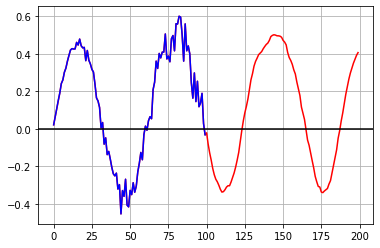

In [36]:
model.eval() 
total_loss = 0.
test_result = torch.Tensor(0)    
truth = torch.Tensor(0)
data, _ = get_batch(val_data, 0,1)
src_data = data
with torch.no_grad():
    for i in range(0, 100):       
        mask = generate_square_subsequent_mask( len(data[-input_window:])  ).to(device)   
        output = model(data[-input_window:], mask)                        
        data = torch.cat((data, output[-1:]))
        
data = data.cpu().view(-1)

# I used this plot to visualize if the model pics up any long therm struccture within the data. 
plt.plot(data,color="red")       
plt.plot(data[:input_window],color="blue")    
plt.grid(True, which='both')
plt.axhline(y=0, color='k')

torch.Size([100, 10, 1])